<img src="NotebookAddons/blackboard-banner.png" width="100%" />
<font face="Calibri">
<br>
<font size="5"><b>Exploring SAR Data and SAR Time Series Analysis using Jupyter Notebooks</b></font>

<br>
<font size="4"><b> Franz J Meyer; University of Alaska Fairbanks & Josef Kellndorfer, <a href="http://earthbigdata.com/" target="_blank">Earth Big Data, LLC</a> </b> <br>
<img src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" />
</font>

<font size="3"> This notebook will introduce you to the analysis of deep multi-temporal SAR image data stacks in the framework of *Jupyter Notebooks*. The Jupyter Notebook environment is easy to launch in any web browser for interactive data exploration with provided or new training data. Notebooks are comprised of text written in a combination of executable python code and markdown formatting including latex style mathematical equations. Another advantage of Jupyter Notebooks is that they can easily be expanded, changed, and shared with new data sets or newly available time series steps. Therefore, they provide an excellent basis for collaborative and repeatable data analysis. <br>

<b>We introduce the following data analysis concepts:</b>

- How to load your own SAR data into Jupyter Notebooks and create a time series stack 
- How to apply calibration constants to covert initial digital number (DN) data into calibrated radar cross section information.
- How to subset images and create a time series of your subset data.
- How to explore the time-series information in SAR data stacks for environmental analysis.

</font>

<hr>
<font face="Calibri" size="5" color="darkred"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>


<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3">In this notebook we will use the following scientific libraries:
<ol type="1">
    <li> <b><a href="https://pandas.pydata.org/" target="_blank">Pandas</a></b> is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality. </li>
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. </li>
    <li> The <b><a href="https://www.pydoc.io/pypi/asf-hyp3-1.1.1/index.html" target="_blank">asf-hyp3 API</a></b> provides useful functions and scripts for accessing and processing SAR data via the Alaska Satellite Facility's Hybrid Pluggable Processing Pipeline, or HyP3 (pronounced "hype"). </li>
<li><b><a href="https://www.scipy.org/about.html" target="_blank">SciPY</a></b> is a library that provides functions for numerical integration, interpolation, optimization, linear algebra and statistics. </li>

</font>

<font face="Calibri" size="3"> Our first step is to <b>import them:</b> </font>

In [1]:
%%capture
import os # for chdir, getcwd, path.exists
import glob # for glob
import re # for match
import json # for loads
import math # for ceil
import datetime # for date
import pyproj
import shutil
import copy

import pandas as pd # for DatetimeIndex
import gdal # for gdalbuildvr, gdalmerge, gdalwarp, gdal_translate, Open
from osgeo import gdal # for Info
import numpy as np # for copy, isnan, log10, ma.masked_where, max, mean, min, percentile, power, unique, var, where 
import matplotlib.pylab as plb # for figure, grid, rcParams, savefig
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as patches  # for Rectangle
from matplotlib import rc
from matplotlib.widgets import RectangleSelector

from asf_hyp3 import API # for get_products, get_subscriptions, login
import scipy # for signal.savgol_filter()
import scipy.signal

from IPython.display import HTML
from IPython.display import Markdown
from IPython.display import display

import asf_notebook as asfn
asfn.jupytertheme_matplotlib_format()

try:
    from hyp3_sdk import Batch
except:
    !python -m pip install hyp3-sdk==0.5 --user
    from hyp3_sdk import Batch


<hr>
<font face="Calibri">

<font size="5"> <b> 1. Load Your Own Data Stack Into the Notebook </b> </font> 

<font size="3"> This notebook assumes that you've created your own data stack over your personal area of interest using the <a href="https://www.asf.alaska.edu/" target="_blank">Alaska Satellite Facility's</a> value-added product system <a href="http://hyp3.asf.alaska.edu/" target="_blank">HyP3</a>. HyP3 is an environment that is used by ASF to prototype value added products and provide them to users to collect feedback. 

This notebook expects <a href="https://media.asf.alaska.edu/uploads/RTC/rtc_atbd_v1.2_final.pdf" target="_blank">Radiometric Terrain Corrected</a> (RTC) image products as input, so be sure to select an RTC process when creating the subscription for your input data within HyP. Prefer a **unique orbit geometry** (ascending or descending) to keep geometric differences between images low. 

We will retrieve HyP3 data via the HyP3 API. As both HyP3 and the Notebook environment sit in the <a href="https://aws.amazon.com/" target="_blank">Amazon Web Services (AWS)</a> cloud, data transfer is quick and cost effective.</font> 
</font>

<font face="Calibri" size="3"><b>Create a HyP3 object and authenticate using your Earthdata Credentials</b> </font>

In [2]:
hyp3 = asfn.hyp3_auth()

Authentication Successful


<hr>
<font face="Calibri" size="3"> Before we download anything, create a working directory for this analysis and change into it. 
<br><br>
<b>Select or create a working directory for the analysis:</b></font>

In [3]:
while True:
    data_dir = asfn.input_path(f"\nPlease enter the name of a directory in which to store your data for this analysis.")
    if os.path.exists(data_dir):
        contents = glob.glob(f'{data_dir}/*')
        if len(contents) > 0:
            choice = asfn.handle_old_data(data_dir, contents)
            if choice == 1:
                shutil.rmtree(data_dir)
                os.mkdir(data_dir)
                break
            elif choice == 2:
                break
            else:
                clear_output()
                continue
        else:
            break
    else:
        os.mkdir(data_dir)
        break

Current working directory: /home/jovyan/notebooks/SAR_Training/English/Master

Please enter the name of a directory in which to store your data for this analysis.
test

********************** WARNING! **********************
The directory test already exists and contains:
• rtc_products
• raster_stack.vrt
• subset
• full_scene.tif
• plots_animations


[1] Delete old data and continue.
[2] Save old data and add the data from this analysis to it.
[3] Save old data and pick a different subdirectory name.
Select option 1, 2, or 3.
1


<font face="Calibri" size="3"><b>Change into the analysis directory:</b></font>

In [4]:
analysis_directory = f"{os.getcwd()}/{data_dir}"
os.chdir(analysis_directory)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/jovyan/notebooks/SAR_Training/English/Master/test


<font face="Calibri" size="3"><b>Create a folder in which to download your RTC products.</b> </font>

In [5]:
rtc_path = "rtc_products"
asfn.new_directory(rtc_path)
products_path = f"{analysis_directory}/{rtc_path}"

Created: rtc_products


<font face="Calibri" size="3"><b>List your projects and select one:</b></font>

In [6]:
projects = asfn.get_RTC_projects(hyp3)

if len(projects) > 0:
    display(Markdown("<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>"))
    print('\nSelect a Project:')
    project_select = asfn.select_parameter(projects)

project_select

<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>


Select a Project:


RadioButtons(layout=Layout(min_width='800px'), options=('Karumba', 'Myanmar_2021', 'Suez_2020', 'Visby'), valu…

<font face="Calibri" size="3"><b>Select a date range of products to download:</b> </font>

In [7]:
project = project_select.value
jobs = hyp3.find_jobs(name=project)
jobs = jobs.filter_jobs(running=False, include_expired=False)
jobs = Batch([job for job in jobs if job.job_type.startswith('RTC')])

if len(jobs) < 1:
    raise ValueError("There are no unexpired RTC products for this project.\nSelect a different project or rerun your jobs in Vertex.")

display(Markdown("<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>"))
print('\nSelect a Date Range:')
dates = asfn.get_job_dates(jobs)
date_picker = asfn.gui_date_picker(dates)
date_picker

<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>


Select a Date Range:


SelectionRangeSlider(description='Dates', index=(0, 72), layout=Layout(width='500px'), options=((' 01/09/2020 …

<font face="Calibri" size="3"><b>Save the selected date range:</b> </font>

In [8]:
date_range = asfn.get_slider_vals(date_picker)
date_range[0] = date_range[0].date()
date_range[1] = date_range[1].date()
print(f"Date Range: {str(date_range[0])} to {str(date_range[1])}")
project = asfn.filter_jobs_by_date(jobs, date_range)

Date Range: 2020-01-09 to 2020-03-21


<font face="Calibri" size="3"><b>Gather the available paths and orbit directions for the remaining products:</b></font>

In [9]:
display(Markdown("<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>"))
project = asfn.get_paths_orbits(project)
paths = set()
orbit_directions = set()
for p in project:
    paths.add(p.path)
    orbit_directions.add(p.orbit_direction)
paths.add('All Paths')
display(Markdown(f"<text style=color:blue><text style='font-size:175%;'>Done.</text></text>"))

<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>

<text style=color:blue><text style='font-size:175%;'>Done.</text></text>

<hr>
<font face="Calibri" size="3"><b>Select a path or paths (use shift or ctrl to select multiple paths):</b></font>

In [11]:
display(Markdown("<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Path:')
path_choice = asfn.select_mult_parameters(paths)
path_choice

<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>


Select a Path:


SelectMultiple(layout=Layout(height='38px', width='175px'), options=('All Paths', 22), value=())

<font face="Calibri" size="3"><b>Save the selected flight path/s:</b></font>

In [12]:
flight_path = path_choice.value
if flight_path:
    if flight_path:
        print(f"Flight Path: {flight_path}")
    else:
        print('Flight Path: All Paths')
else:
    print("WARNING: You must select a flight path in the previous cell, then rerun this cell.")

Flight Path: ('All Paths',)


<font face="Calibri" size="3"><b>Select an orbit direction:</b></font>

In [13]:
if len(orbit_directions) > 1:
    display(Markdown("<text style='color:red;'>Note: After selecting a flight direction, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:red;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Flight Direction:')
direction_choice = asfn.select_parameter(orbit_directions, 'Direction:')
direction_choice


Select a Flight Direction:


RadioButtons(description='Direction:', layout=Layout(min_width='800px'), options=('DESCENDING',), value='DESCE…

<font face="Calibri" size="3"><b>Save the selected orbit direction:</b></font>

In [14]:
direction = direction_choice.value
print(f"Orbit Direction: {direction}")

Orbit Direction: DESCENDING


<font face="Calibri" size="3"><b>Filter jobs by path and orbit direction:</b></font>

In [16]:
project = asfn.filter_jobs_by_path(project, flight_path)
project = asfn.filter_jobs_by_orbit(project, direction)
print(f"There are {len(project)} products to download.")

There are 7 products to download.


<font face="Calibri" size="3"><b>Download the products, unzip them into the rtc_products directory, and delete the zip files:</b> </font>

In [17]:
print(f"\nProject: {project.jobs[0].name}")
project_zips = project.download_files()
for z in project_zips:
    asfn.asf_unzip(products_path, str(z))
    z.unlink()


Project: Visby




Extracting: S1A_IW_20200321T050729_DVP_RTC30_G_gpuned_BFCD.zip
Extracting: S1A_IW_20200309T050729_DVP_RTC30_G_gpuned_1C76.zip
Extracting: S1A_IW_20200202T050729_DVP_RTC30_G_gpuned_5197.zip
Extracting: S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA.zip
Extracting: S1A_IW_20200121T050730_DVP_RTC30_G_gpuned_CDCA.zip
Extracting: S1A_IW_20200226T050729_DVP_RTC30_G_gpuned_4413.zip
Extracting: S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5.zip


<font face="Calibri" size="3"><b>Determine the available polarizations:</b></font>

In [18]:
polarizations = asfn.get_RTC_polarizations(rtc_path)
polarization_power_set = asfn.get_power_set(polarizations)

<font face="Calibri" size="3"><b>Select a polarization:</b></font>

In [19]:
polarization_choice = asfn.select_parameter(sorted(polarization_power_set), 'Polarizations:')
polarization_choice

RadioButtons(description='Polarizations:', layout=Layout(min_width='800px'), options=('VH', 'VH and VV', 'VV')…

<font face="Calibri" size="3"><b>Create a paths variable, holding the relative path to the tiffs in the selected polarization/s:</b></font>

In [20]:
polarization = polarization_choice.value
print(polarization)
if len(polarization) == 2:
    regex = "\w[\--~]{{5,300}}(_|-){}.(tif|tiff)$".format(polarization)
    dbl_polar = False
else:
    regex = "\w[\--~]{{5,300}}(_|-){}(v|V|h|H).(tif|tiff)$".format(polarization[0])
    dbl_polar = True

VH


<hr>
<font face="Calibri" size="3"> You may notice duplicates in your acquisition dates. As HyP3 processes SAR data on a frame-by-frame basis, duplicates may occur if your area of interest is covered by two consecutive  image frames. In this case, two separate images are generated that need to be merged together before time series processing can commence.
<br><br>
<b>Write functions to collect and print the paths of the tiffs:</b></font>

In [21]:
def get_tiff_paths(regex, polarization, pths):
    tiff_paths = []
    for pth in glob.glob(pths):
        tiff_path = re.search(regex, pth)
        if tiff_path:
            tiff_paths.append(pth)
    return tiff_paths

def print_tiff_paths(tiff_paths):
    print("Tiff paths:")
    for p in tiff_paths:
        print(f"{p}\n")

<font face="Calibri" size="3"><b>Write a function to collect the product acquisition dates:</b></font>

In [22]:
def get_dates(product_list):
    dates = []
    for product in product_list:
        dates.append(asfn.date_from_product_name(product).split('T')[0])
    return dates

<font face="Calibri" size="3"><b>Collect and print the paths of the tiffs:</b></font>

In [23]:
tiff_pth = f"{rtc_path}/*/*{polarization[0]}*.tif*"    
tiff_paths = get_tiff_paths(regex, polarization, tiff_pth)
print_tiff_paths(tiff_paths)

Tiff paths:
rtc_products/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA_VH.tif

rtc_products/S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5/S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5_VH.tif

rtc_products/S1A_IW_20200121T050730_DVP_RTC30_G_gpuned_CDCA/S1A_IW_20200121T050730_DVP_RTC30_G_gpuned_CDCA_VH.tif

rtc_products/S1A_IW_20200309T050729_DVP_RTC30_G_gpuned_1C76/S1A_IW_20200309T050729_DVP_RTC30_G_gpuned_1C76_VH.tif

rtc_products/S1A_IW_20200226T050729_DVP_RTC30_G_gpuned_4413/S1A_IW_20200226T050729_DVP_RTC30_G_gpuned_4413_VH.tif

rtc_products/S1A_IW_20200202T050729_DVP_RTC30_G_gpuned_5197/S1A_IW_20200202T050729_DVP_RTC30_G_gpuned_5197_VH.tif

rtc_products/S1A_IW_20200321T050729_DVP_RTC30_G_gpuned_BFCD/S1A_IW_20200321T050729_DVP_RTC30_G_gpuned_BFCD_VH.tif



<hr>
<font face="Calibri" size="4"> <b>1.2 Fix multiple UTM Zone-related issues</b> <br>
<br>
<font face="Calibri" size="3">Fix multiple UTM Zone-related issues should they exist in your data set. If multiple UTM zones are found, the following code cells will identify the predominant UTM zone and reproject the rest into that zone. This step must be completed prior to merging frames or performing any analysis.</font>
<br><br>
<font face="Calibri" size="3"><b>Use gdal.Info to determine the UTM definition types and zones in each product:</b></font>

In [24]:
coord_choice = asfn.select_parameter(["UTM", "Lat/Long"], 'Coord Systems:')
coord_choice

RadioButtons(description='Coord Systems:', layout=Layout(min_width='800px'), options=('UTM', 'Lat/Long'), valu…

In [25]:
utm_zones = []
utm_types = []
print('Checking UTM Zones in the data stack ...\n')
for k in range(0, len(tiff_paths)):
    info = (gdal.Info(tiff_paths[k], options = ['-json']))
    info = json.dumps(info)
    info = (json.loads(info))['coordinateSystem']['wkt']
    zone = info.split('ID')[-1].split(',')[1][0:-2]
    utm_zones.append(zone)
    typ = info.split('ID')[-1].split('"')[1]
    utm_types.append(typ)
print(f"UTM Zones:\n {utm_zones}\n")
print(f"UTM Types:\n {utm_types}")

Checking UTM Zones in the data stack ...

UTM Zones:
 ['32633', '32633', '32633', '32633', '32633', '32633', '32633']

UTM Types:
 ['EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG']


<font face="Calibri" size="3"><b>Identify the most commonly used UTM Zone in the data:</b></font>

In [26]:
if coord_choice.value == 'UTM':
    utm_unique, counts = np.unique(utm_zones, return_counts=True)
    a = np.where(counts == np.max(counts))
    predominant_utm = utm_unique[a][0]
    print(f"Predominant UTM Zone: {predominant_utm}")
else:
    predominant_utm = '4326'

Predominant UTM Zone: 32633


<font face="Calibri" size="3"><b>Reproject images with errant UTMs to the predominant UTM:</b></font>

In [27]:
if coord_choice.value == 'UTM':
    reproject_indicies = [i for i, j in enumerate(utm_zones) if j != predominant_utm] #makes list of indicies in utm_zones that need to be reprojected
#elif coord_choice.value == 'Lat/Long':
#    reproject_indicies = [i for i, j in enumerate(utm_zones)]
    print('--------------------------------------------')
    print('Reprojecting %4.1f files' %(len(reproject_indicies)))
    print('--------------------------------------------')
    for k in reproject_indicies:
        temppath = tiff_paths[k].strip()
        _, product_name, tiff_name = temppath.split('/')
        if coord_choice.value == 'UTM':
            cmd = f"gdalwarp -overwrite rtc_products/{product_name}/{tiff_name} rtc_products/{product_name}/r{tiff_name} -s_srs {utm_types[k]}:{utm_zones[k]} -t_srs EPSG:{predominant_utm}"
        elif coord_choice.value == 'Lat/Long':
            cmd = f"gdalwarp -overwrite rtc_products/{product_name}/{tiff_name} rtc_products/{product_name}/r{tiff_name} -s_srs {utm_types[k]}:{utm_zones[k]} -t_srs EPSG:4326"
            predominant_utm = '4326'   
        #print(f"Calling the command: {cmd}")
        !{cmd}
        rm_command = f"rm {tiff_paths[k].strip()}"
        #print(f"Calling the command: {rm_command}")
        !{rm_command}

--------------------------------------------
Reprojecting  0.0 files
--------------------------------------------


<font face="Calibri" size="3"><b>Update tiff_paths with any new filenames created during reprojection:</b></font>

In [28]:
tiff_paths = get_tiff_paths(regex, polarization, tiff_pth)
print_tiff_paths(tiff_paths)

Tiff paths:
rtc_products/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA_VH.tif

rtc_products/S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5/S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5_VH.tif

rtc_products/S1A_IW_20200121T050730_DVP_RTC30_G_gpuned_CDCA/S1A_IW_20200121T050730_DVP_RTC30_G_gpuned_CDCA_VH.tif

rtc_products/S1A_IW_20200309T050729_DVP_RTC30_G_gpuned_1C76/S1A_IW_20200309T050729_DVP_RTC30_G_gpuned_1C76_VH.tif

rtc_products/S1A_IW_20200226T050729_DVP_RTC30_G_gpuned_4413/S1A_IW_20200226T050729_DVP_RTC30_G_gpuned_4413_VH.tif

rtc_products/S1A_IW_20200202T050729_DVP_RTC30_G_gpuned_5197/S1A_IW_20200202T050729_DVP_RTC30_G_gpuned_5197_VH.tif

rtc_products/S1A_IW_20200321T050729_DVP_RTC30_G_gpuned_BFCD/S1A_IW_20200321T050729_DVP_RTC30_G_gpuned_BFCD_VH.tif



<hr>
<font face="Calibri" size="4"> <b>1.3 Merge multiple frames from the same date.</b></font>
<br><br>
<font face="Calibri" size="3"><b>Create a list aquisition dates:</b></font>

In [29]:
dates = get_dates(tiff_paths)
print(dates)

['20200109', '20200214', '20200121', '20200309', '20200226', '20200202', '20200321']


<font face="Calibri" size="3"><b>Create a set containing each represented date:</b></font>

In [30]:
unique_dates = set(dates)
print(unique_dates)

{'20200202', '20200309', '20200226', '20200214', '20200121', '20200321', '20200109'}


<font face="Calibri" size="3"><b>Determine which dates have multiple frames. Create a dictionary with each date as a key linked to a value set as an empty string:</b></font>

In [31]:
dup_date_batches = [{}]
for date in unique_dates:
    count = 0
    for d in dates:
        if date == d:
            count +=1
    if count > 1:
        dup_date_batches[0].update({date : ""})
if dbl_polar:
    dup_date_batches.append(copy.deepcopy(dup_date_batches[0]))
print(dup_date_batches)

[{}]


<font face="Calibri" size="3"><b>Update the key values in dup_paths with the string paths to all the tiffs for each date:</b></font>

In [33]:
if dbl_polar:
    polar_list = [polarization.split(' ')[0], polarization.split(' ')[2]]
else:
    polar_list = [polarization]

for i, polar in enumerate(polar_list):
    polar_regex = f"(\w|/)*_{polar}.(tif|tiff)$"
    polar_paths = get_tiff_paths(polar_regex, polar, tiff_pth)
    for pth in polar_paths:
        date = asfn.date_from_product_name(pth).split('T')[0]
        if date in dup_date_batches[i]:
            dup_date_batches[i][date] = f"{dup_date_batches[i][date]} {pth}"

for d in dup_date_batches:
    print(d)
    print("\n")

{}




<font face="Calibri" size="3"><b>Merge all the frames for each date.</b></font>

In [34]:
for i, dup_dates in enumerate(dup_date_batches):
    for dup_date in dup_dates:
        output = f"{dup_dates[dup_date].split('/')[0]}/{dup_dates[dup_date].split('/')[1]}/new{dup_dates[dup_date].split('/')[2].split(' ')[0]}"
        gdal_command = f"gdal_merge.py -o {output} {dup_dates[dup_date]}"
        print(f"\n\nCalling the command: {gdal_command}\n")
        !{gdal_command}
        for pth in dup_dates[dup_date].split(' '):
            if pth and path_exists(pth):
                os.remove(pth)
                print(f"Deleting: {pth}")

<hr>
<font face="Calibri" size="3"> <b>Verify that all duplicate dates were resolved:</b> </font>

In [35]:
tiff_paths = get_tiff_paths(regex, polarization, tiff_pth)
for polar in polar_list:
    dates = get_dates(tiff_paths)
    if len(dates) != len(set(dates)):
        print(f"Duplicate dates still present!")
    else:
        print(f"No duplicate dates are associated with {polar} polarization.")

No duplicate dates are associated with VH polarization.


<font face="Calibri" size="3"><b>Print the updated paths of the tiffs:</b></font>

In [36]:
#print_tiff_paths(tiff_paths) # uncomment to view paths

<hr>
<font face="Calibri">

<font size="5"> <b> 2. Create Subset and Stack Up Your Data </b> </font> 

<font size="3"> Now you are ready to work with your data. The next cells allow you to select an area of interest (AOI; via bounding-box corner coordinates) for your data analysis. Once selected, the AOI is being extracted and a data stack is formed.

<b>Create a string containing paths to one image for each area represented in the stack:</b>
</font> 
</font>

In [37]:
to_merge = {}
for pth in tiff_paths:
    info = (gdal.Info(pth, options = ['-json']))
    info = json.dumps(info)
    info = (json.loads(info))['wgs84Extent']['coordinates']
    
    coords = [info[0][0], info[0][3]]
    for i in range(0, 2):
        for j in range(0, 2):
            coords[i][j] = round(coords[i][j])
    str_coords = f"{str(coords[0])}{str(coords[1])}"
    if str_coords not in to_merge:
        to_merge.update({str_coords: pth})
print(to_merge)
print()
merge_paths = ""
for pth in to_merge:
    merge_paths = f"{merge_paths} {to_merge[pth]}"
    
print(merge_paths)

{'[16, 58][20, 58]': 'rtc_products/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA_VH.tif'}

 rtc_products/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA_VH.tif


<font face="Calibri" size="3"><b>Merge the images, creating a full scene for display in the Area-Of-Interest selector:</b></font>

In [38]:
full_scene = f"{analysis_directory}/full_scene.tif"
if os.path.exists(full_scene):
    os.remove(full_scene)
gdal_command = f"gdal_merge.py -o {full_scene} {merge_paths}"
!{gdal_command}

0...10...20...30...40...50...60...70...80...90...100 - done.


<font face="Calibri" size="3"><b>Create a VRT of the full scene:</b></font>

In [39]:
image_file = f"{analysis_directory}/raster_stack.vrt"
!gdalbuildvrt -separate $image_file -overwrite $full_scene

0...10...20...30...40...50...60...70...80...90...100 - done.


<font face="Calibri" size="3"><b>Convert the VRT into an array:</b> </font>

In [40]:
img = gdal.Open(image_file)
rasterstack = img.ReadAsArray()

<font face="Calibri" size="3"><b>Print the number of bands, pixels, and lines:</b> </font>

In [41]:
print(img.RasterCount) # Number of Bands
print(img.RasterXSize) # Number of Pixels
print(img.RasterYSize) # Number of Lines

1
9622
6825


<font face="Calibri" size="3"><b>Create an AOI selector from an image in your raster stack:</b> </font>

<text style=color:blue><b>Area of Interest Selector Tips:
</b></text>

<text style=color:blue>- This plot uses "matplotlib notebook", whereas the other plots in this notebook use "matplotlib inline".</text>

<text style=color:blue>-  If you run this cell out of sequence and the plot is not interactive, rerun the "%matplotlib notebook" code cell.</text>

<text style=color:blue>- Use the pan tool to pan with the left mouse button.</text>

<text style=color:blue>- Use the pan tool to zoom with the right mouse button.</text>

<text style=color:blue>- You can also zoom with a selection box using the zoom to rectangle tool.</text>

<text style=color:blue>- To turn off the pan or zoom to rectangle tool so you can select an AOI, click the selected tool button again.</text>

<text style=color:darkred><b>IMPORTANT!</b></text>

<text style=color:darkred>- Upon loading the AOI selector, the selection tool is already active.</text>

<text style=color:darkred>- Click, drag, and release the left mouse button to select an area.</text>

<text style=color:darkred>- The square tool icon in the menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>

<text style=color:darkred>- If you select any tool, you must toggle it off before you can select an AOI</text>

<IPython.core.display.Javascript object>


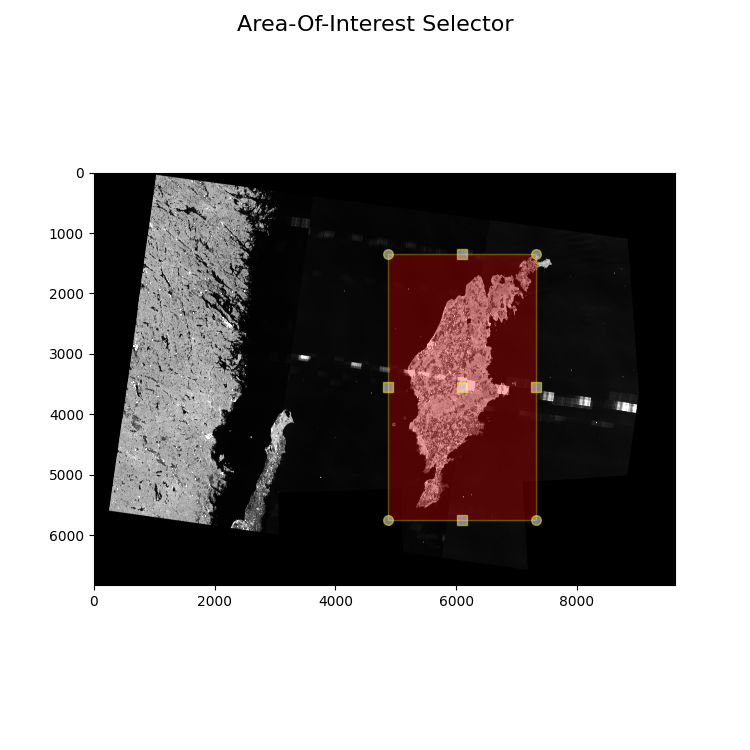

In [43]:
%matplotlib notebook
fig_xsize = 7.5
fig_ysize = 7.5
aoi = asfn.AOI_Selector(rasterstack, fig_xsize, fig_ysize)

<font face="Calibri" size="3"><b>Gather and define projection details:</b> </font>

In [44]:
geotrans = img.GetGeoTransform()
projlatlon = pyproj.Proj('EPSG:4326') # WGS84
projimg = pyproj.Proj(f'EPSG:{predominant_utm}')

<font face="Calibri" size="3"><b>Write a function to convert the pixel, line coordinates from the AOI selector into geographic coordinates in the stack's EPSG projection:</b> </font>

In [45]:
def geolocation(x, y, geotrans,latlon=True):
    ref_x = geotrans[0]+x*geotrans[1]
    ref_y = geotrans[3]+y*geotrans[5]
    if latlon:
        ref_y, ref_x = pyproj.transform(projimg, projlatlon, ref_x, ref_y)
    return [ref_x, ref_y]

<font face="Calibri" size="3"><b>Call geolocation to gather the aoi_coords:</b> </font>

In [46]:
aoi_coords = [geolocation(aoi.x1, aoi.y1, geotrans, latlon=False), geolocation(aoi.x2, aoi.y2, geotrans, latlon=False)]
print(f"aoi_coords in EPSG {predominant_utm}: {aoi_coords}")

aoi_coords in EPSG 32633: [[676348.6870967741, 6437669.109677419], [749848.3516129033, 6305568.361290323]]


<font face="Calibri" size="3"><b>Collect the paths to the tiffs:</b> </font>

In [47]:
tiff_paths = get_tiff_paths(regex, polarization, tiff_pth)
print_tiff_paths(tiff_paths)

Tiff paths:
rtc_products/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA_VH.tif

rtc_products/S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5/S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5_VH.tif

rtc_products/S1A_IW_20200121T050730_DVP_RTC30_G_gpuned_CDCA/S1A_IW_20200121T050730_DVP_RTC30_G_gpuned_CDCA_VH.tif

rtc_products/S1A_IW_20200309T050729_DVP_RTC30_G_gpuned_1C76/S1A_IW_20200309T050729_DVP_RTC30_G_gpuned_1C76_VH.tif

rtc_products/S1A_IW_20200226T050729_DVP_RTC30_G_gpuned_4413/S1A_IW_20200226T050729_DVP_RTC30_G_gpuned_4413_VH.tif

rtc_products/S1A_IW_20200202T050729_DVP_RTC30_G_gpuned_5197/S1A_IW_20200202T050729_DVP_RTC30_G_gpuned_5197_VH.tif

rtc_products/S1A_IW_20200321T050729_DVP_RTC30_G_gpuned_BFCD/S1A_IW_20200321T050729_DVP_RTC30_G_gpuned_BFCD_VH.tif



<font face="Calibri" size="3"><b>Create a subdirectory in which to store the subset tiffs:</b> </font>

In [48]:
print("Choose a directory name in which to store the subset geotiffs.")
print("Note: this will sit alongside the directory containing your pre-subset geotiffs.")
while True:
    sub_name = input()
    if sub_name == "":
        print("Please enter a valid directory name")
        continue
    else:
        break

Choose a directory name in which to store the subset geotiffs.
Note: this will sit alongside the directory containing your pre-subset geotiffs.
subset


<font size="3"><b>Subset the tiffs and move them from the individual product directories into their own directory, /tiffs:</b></font> 

In [50]:
subset_dir = f"{analysis_directory}/{sub_name}/"
asfn.new_directory(subset_dir)
for i, tiff_path in enumerate(tiff_paths):
    for name_chunk in tiff_path.split('/')[-1].split('_'):
        nums = list(range(48, 58))
        if len(name_chunk) == 15 and ord(name_chunk[0]) in nums: 
            date = name_chunk.split('T')[0]
            break
        elif len(name_chunk) == 8 and ord(name_chunk[0]) in nums:
                date = name_chunk
                break
    polar = tiff_path.split('/')[-1].split('.')[0][-2:]
    print(f"\nProduct #{i+1}:")
    gdal_command = f"gdal_translate -projwin {aoi_coords[0][0]} {aoi_coords[0][1]} {aoi_coords[1][0]} {aoi_coords[1][1]} -projwin_srs 'EPSG:{predominant_utm}' -co \"COMPRESS=DEFLATE\" -a_nodata 0 {tiff_path} {subset_dir}{date}_{polar}.tiff"
    print(f"Calling the command: {gdal_command}")
    !{gdal_command}

Created: /home/jovyan/notebooks/SAR_Training/English/Master/test/subset/

Product #1:
Calling the command: gdal_translate -projwin 676348.6870967741 6437669.109677419 749848.3516129033 6305568.361290323 -projwin_srs 'EPSG:32633' -co "COMPRESS=DEFLATE" -a_nodata 0 rtc_products/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA/S1A_IW_20200109T050730_DVP_RTC30_G_gpuned_D5AA_VH.tif /home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200109_VH.tiff
Input file size is 9622, 6825
0...10...20...30...40...50...60...70...80...90...100 - done.

Product #2:
Calling the command: gdal_translate -projwin 676348.6870967741 6437669.109677419 749848.3516129033 6305568.361290323 -projwin_srs 'EPSG:32633' -co "COMPRESS=DEFLATE" -a_nodata 0 rtc_products/S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5/S1A_IW_20200214T050729_DVP_RTC30_G_gpuned_92A5_VH.tif /home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200214_VH.tiff
Input file size is 9621, 6825
0...10...20...30...40...50...60...70

<font size="3"><b>Grab the updated paths of the images:</b></font>

In [51]:
sub_pth = f"{subset_dir}/*.tif*"
subset_regex = "\w[\--~]{2,200}.(tif|tiff)$"
tiff_paths = get_tiff_paths(subset_regex, polarization, sub_pth)
print_tiff_paths(tiff_paths)

Tiff paths:
/home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200121_VH.tiff

/home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200202_VH.tiff

/home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200321_VH.tiff

/home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200309_VH.tiff

/home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200214_VH.tiff

/home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200109_VH.tiff

/home/jovyan/notebooks/SAR_Training/English/Master/test/subset/20200226_VH.tiff



<font size="3"><b>Delete any subset tifs that are filled with NaNs and contain no data.</b></font>

In [53]:
asfn.remove_nan_filled_tifs(subset_dir, tiff_paths)
print(f"\nThere are {len(tiff_paths)} tiffs remaining in the image stack.")

GeoTiffs Examined: 7
GeoTiffs Removed:  0

There are 7 tiffs remaining in the image stack.


<font size="3"><b>Update the list of dates and tiff_paths after removing NaN filled images:</b></font>

In [54]:
dates = []
pth = glob.glob(f"{subset_dir}/*.tif*")
pth.sort()
for p in pth:
    date = os.path.basename(p)[0:8]
    dates.append(date)
    print(date)

tiff_paths = get_tiff_paths(subset_regex, polarization, sub_pth)
# print_tiff_paths(tiff_paths) # uncomment to print tiff paths

20200109
20200121
20200202
20200214
20200226
20200309
20200321


<hr>
<font face="Calibri" size="3"> Now we stack up the data by creating a virtual raster table with links to all subset data files: </font>
<br><br>
<font size="3"><b>Create the virtual raster table for the subset GeoTiffs:</b></font>

In [55]:
!gdalbuildvrt -separate raster_stack.vrt $subset_dir/*.tif*

0...10...20...30...40...50...60...70...80...90...100 - done.


<hr>
<font face="Calibri">

<font size="5"> <b> 3. Now You Can Work With Your Data </b> </font> 

<font size="3"> Now you are ready to perform time series analysis on your data stack
</font> 
</font>

<br>
<font face="Calibri" size="4"> <b> 3.1 Define Data Directory and Path to VRT </b> </font> 
<br><br>
<font face="Calibri" size="3"><b>Create a variable containing the VRT filename:</b></font>

In [56]:
image_file = "raster_stack.vrt"

<font face="Calibri" size="3"><b>Create an index of timedelta64 data with Pandas:</b></font>

In [57]:
time_index = pd.DatetimeIndex(dates)

<font face="Calibri" size="3"><b>Print the bands and dates for all images in the virtual raster table (VRT):</b></font>

In [58]:
j = 1
print(f"Bands and dates for {image_file}")
for i in time_index:
    print("{:4d} {}".format(j, i.date()), end=' ')
    j += 1
    if j%5 == 1: 
        print()

Bands and dates for raster_stack.vrt
   1 2020-01-09    2 2020-01-21    3 2020-02-02    4 2020-02-14    5 2020-02-26 
   6 2020-03-09    7 2020-03-21 

<hr>
<br>
<font face="Calibri" size="4"> <b> 3.2 Open Your Data Stack and Visualize Some Layers </b> </font> 

<font face="Calibri" size="3"> We will <b>open your VRT</b> and visualize some layers using Matplotlib. </font>

In [59]:
img = gdal.Open(image_file)

<font face="Calibri" size="3"><b>Print the bands, pixels, and lines:</b></font>

In [60]:
print(f"Number of  bands: {img.RasterCount}")
print(f"Number of pixels: {img.RasterXSize}")
print(f"Number of  lines: {img.RasterYSize}")

Number of  bands: 7
Number of pixels: 2450
Number of  lines: 4403


<font face="Calibri" size="3"><b>Read in raster data for the first two bands:</b></font>

In [61]:
raster_1 = img.GetRasterBand(1).ReadAsArray() # change the number passed to GetRasterBand() to 
where_are_NaNs = np.isnan(raster_1)           # read rasters from different bands
raster_1[where_are_NaNs] = 0

raster_2 = img.GetRasterBand(2).ReadAsArray() #must pass a valid band number to GetRasterBand()
where_are_NaNs = np.isnan(raster_2)
raster_2[where_are_NaNs] = 0

<font face="Calibri" size="3"><b>Plot images and histograms for bands 1 and 2:</b></font>

Text(0.5, 1.0, 'Histogram Band 2 2020-01-21')

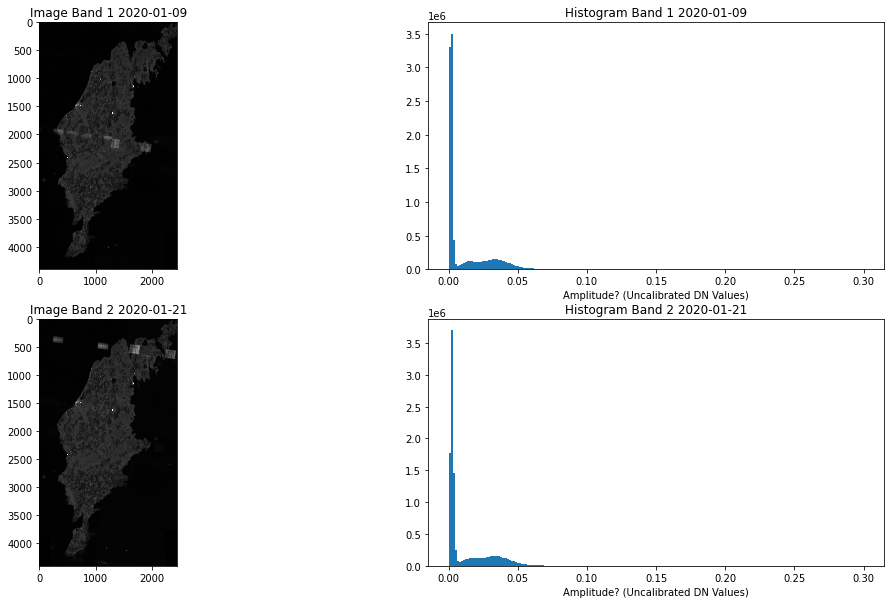

In [62]:
%matplotlib inline
import matplotlib.pylab as plb
# Setup the pyplot plots
fig = plb.figure(figsize=(18,10)) # Initialize figure with a size
ax1 = fig.add_subplot(221)  # 221 determines: 2 rows, 2 plots, first plot
ax2 = fig.add_subplot(222)  # 222 determines: 2 rows, 2 plots, second plot
ax3 = fig.add_subplot(223)  # 223 determines: 2 rows, 2 plots, third plot
ax4 = fig.add_subplot(224)  # 224 determines: 2 rows, 2 plots, fourth plot

# Plot the band 1 image
band_number = 1
ax1.imshow(raster_1,cmap='gray', vmin=0, vmax=0.2) #,vmin=2000,vmax=10000)
ax1.set_title('Image Band {} {}'.format(band_number, time_index[band_number-1].date()))

# Flatten the band 1 image into a 1 dimensional vector and plot the histogram:
h = ax2.hist(raster_1.flatten(), bins=200, range=(0, 0.3))
ax2.xaxis.set_label_text('Amplitude? (Uncalibrated DN Values)')
ax2.set_title('Histogram Band {} {}'.format(band_number, time_index[band_number-1].date()))

# Plot the band 2 image
band_number = 2
ax3.imshow(raster_2,cmap='gray', vmin=0, vmax=0.2) #,vmin=2000,vmax=10000)
ax3.set_title('Image Band {} {}'.format(band_number, time_index[band_number-1].date()))

# Flatten the band 2 image into a 1 dimensional vector and plot the histogram:
h = ax4.hist(raster_2.flatten(),bins=200,range=(0,0.3))
ax4.xaxis.set_label_text('Amplitude? (Uncalibrated DN Values)')
ax4.set_title('Histogram Band {} {}'.format(band_number, time_index[band_number-1].date()))

<hr>
<br>
<font face="Calibri" size="4"> <b> 3.3 Calibration and Data Conversion between dB and Power Scales </b> </font>

<font face="Calibri" size="3"> <font color='rgba(200,0,0,0.2)'> <b>Note, that if your data were generated by HyP3, this step is not necessary!</b> HyP3 performs the full data calibration and provides you with calibrated data in power scale. </font>
    
If, your data is from a different source, however, calibration may be necessary to ensure that image gray values correspond to proper radar cross section information. 

Calibration coefficients for SAR data are often defined in the decibel (dB) scale due to the high dynamic range of the imaging system. For the L-band ALOS PALSAR data at hand, the conversion from uncalibrated DN values to calibrated radar cross section values in dB scale is performed by applying a standard **calibration factor of -83 dB**. 
<br> <br>
$\gamma^0_{dB} = 20 \cdot log10(DN) -83$

The data at hand are radiometrically terrain corrected images, which are often expressed as terrain flattened $\gamma^0$ backscattering coefficients. For forest and land cover monitoring applications $\gamma^o$ is the preferred metric.

<b>To apply the calibration constant for your data and export in *dB* scale, uncomment the following code cell</b>: </font> 

In [63]:
 #caldB=20*np.log10(rasterstack)-83

<font face="Calibri" size="3"> While **dB**-scaled images are often "visually pleasing", they are often not a good basis for mathematical operations on data. For instance, when we compute the mean of observations, it makes a difference whether we do that in power or dB scale. Since dB scale is a logarithmic scale, we cannot simply average data in that scale. 
    
Please note that the **correct scale** in which operations need to be performed **is the power scale.** This is critical, e.g. when speckle filters are applied, spatial operations like block averaging are performed, or time series are analyzed.

To **convert from dB to power**, apply: $\gamma^o_{pwr} = 10^{\frac{\gamma^o_{dB}}{10}}$ </font>

In [64]:
#calPwr=np.power(10.,caldB/10.)

<hr>
<br>
<font face="Calibri" size="4"> <b> 3.4 Create a Time Series Animation </b> </font>

<font face="Calibri" size="3">Now we are ready to create a time series animation from the calibrated SAR data.
<br><br>
<b>Create a directory in which to store our plots and animations:</b>
</font> 

In [66]:
output_path = 'plots_animations'
asfn.new_directory(output_path)

Created: plots_animations


<font face="Calibri" size="3"> Now we are ready to <b>create a time series animation</b> from the calibrated SAR data. </font> 

In [67]:
band = img.GetRasterBand(1)
raster0 = band.ReadAsArray()
band_number = 0 # Needed for updates
raster_stack = img.ReadAsArray()
img = None

<font face="Calibri" size="3"><b>Create a masked raster stack:</b></font> 

In [68]:
raster_stack_masked = np.ma.masked_where(raster_stack==0, raster_stack)

<font face="Calibri" size="3"><b>Generate a matplotlib time-series animation:</b></font> 

In [69]:
%%capture
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
ax.axis('off')
vmin = np.percentile(raster_stack.flatten(), 5)
vmax = np.percentile(raster_stack.flatten(), 95)

r0dB = 20 * np.ma.log10(raster0) - 83

im = ax.imshow(raster0, cmap='gray', vmin=vmin, vmax=vmax)
ax.set_title("{}".format(time_index[0].date()))

def animate(i):
    ax.set_title("{}".format(time_index[i].date()))
    im.set_data(raster_stack[i])

# Interval is given in milliseconds
ani = animation.FuncAnimation(fig, animate, frames=raster_stack.shape[0], interval=400)

<font face="Calibri" size="3"><b>Configure matplotlib's RC settings for the animation:</b></font> 

In [70]:
rc('animation', embed_limit=40971520.0) 

<font face="Calibri" size="3"><b>Create a javascript animation of the time-series running inline in the notebook:</b></font> 

In [71]:
HTML(ani.to_jshtml())

<font face="Calibri" size="3"><b>Delete the dummy png</b> that was saved to the current working directory while generating the javascript animation in the last code cell.</font> 

In [72]:
try:
    os.remove('None0000000.png')
except FileNotFoundError:
    pass

<font face="Calibri" size="3"><b>Save the animation (animation.gif):</b> </font> 

In [73]:
ani.save(f"{output_path}/animation.gif", writer='pillow', fps=2)

<br>
<hr>
<font face="Calibri" size="4"> <b> 3.5 Plot the Time Series of Means Calculated Across the Subset </b> </font>

<font face="Calibri" size="3"> To create the time series of means, we will go through the following steps:
1. Ensure that you use the data in **power scale** ($\gamma^o_{pwr}$) for your mean calculations.
2. compute means.
3. convert the resulting mean values into dB scale for visualization.
4. plot time series of means. </font> 
<br><br>
<font face="Calibri" size="3"> <b>Compute the means:</b> </font>

In [74]:
rs_means_pwr = np.mean(raster_stack_masked, axis=(1, 2))

<font face="Calibri" size="3"><b>Convert resulting mean value time-series to dB scale for visualization:</b></font>

In [75]:
rs_means_dB = 10.*np.ma.log10(rs_means_pwr)

<font face="Calibri" size="3"><b>Plot and save the time series of means (RCSoverTime.png):</b></font>

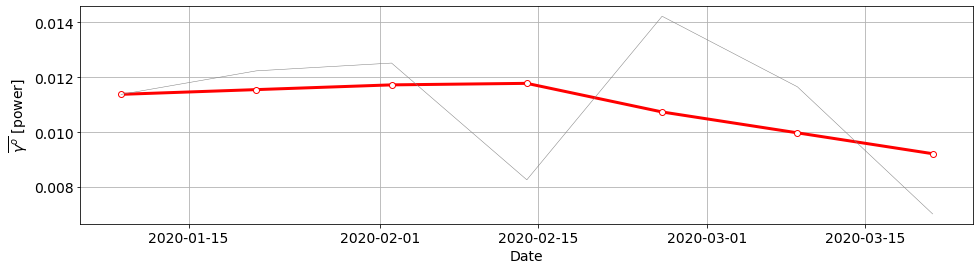

In [76]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16, 4))
ax1 = fig.subplots()
window_length = len(rs_means_pwr)-1
if window_length % 2 == 0:
    window_length -= 1
polyorder = math.ceil(window_length*0.1)
yhat = scipy.signal.savgol_filter(rs_means_pwr, window_length, polyorder) 
ax1.plot(time_index, yhat, color='red', marker='o', markerfacecolor='white', linewidth=3, markersize=6)
ax1.plot(time_index, rs_means_pwr, color='gray', linewidth=0.5)
plt.grid()
ax1.set_xlabel('Date')
ax1.set_ylabel('$\overline{\gamma^o}$ [power]')
plt.savefig(f'{output_path}/RCSoverTime.png', dpi=72, transparent='true')

<br>
<hr>
<font face="Calibri" size="4"> <b> 3.6 Calculate Coefficient of Variance </b> </font>

<font face="Calibri" size="3"> The coefficient of variance describes how much the $\sigma_{0}$ or $\gamma_{0}$ measurements in a pixel vary over time. Hence, the coefficient of variance can indicate different vegetation cover and soil moisture regimes in your area.</font> 
<br><br>
<font face="Calibri" size="3"><b>Write a function to convert our plots into GeoTiffs:</b></font> 

In [77]:
def geotiff_from_plot(source_image, out_filename, extent, cmap=None, vmin=None, vmax=None, interpolation=None, dpi=300):
    assert "." not in out_filename, 'Error: Do not include the file extension in out_filename'
    assert type(extent) == list and len(extent) == 2 and len(extent[0]) == 2 and len(
        extent[1]) == 2, 'Error: extent must be a list in the form [[upper_left_x, upper_left_y], [lower_right_x, lower_right_y]]'
    
    plt.figure()
    plt.axis('off')
    plt.imshow(source_image, cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interpolation)
    temp = f"{out_filename}_temp.png"
    plt.savefig(temp, dpi=dpi, transparent='true', bbox_inches='tight', pad_inches=0)

    cmd = f"gdal_translate -of Gtiff -a_ullr {extent[0][0]} {extent[0][1]} {extent[1][0]} {extent[1][1]} -a_srs EPSG:{predominant_utm} {temp} {out_filename}.tiff"
    !{cmd}
    try:
        os.remove(temp)
    except FileNotFoundError:
        pass

<font face="Calibri" size="3"><b>Plot the Coefficient of Variance Map and save it as a png (Coeffvar.png):</b> </font> 

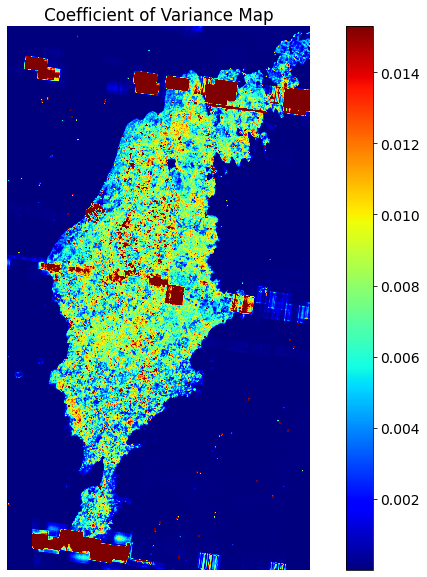

In [78]:
test = np.var(raster_stack,0)
mtest = np.mean(raster_stack[raster_stack.nonzero()],0)
coeffvar = test/(mtest+0.001)

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(13, 10))
ax = fig.subplots()
ax.axis('off')
vmin = np.percentile(coeffvar.flatten(), 5)
vmax = np.percentile(coeffvar.flatten(), 95)
ax.set_title('Coefficient of Variance Map')

im = ax.imshow(coeffvar, cmap='jet', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
plt.savefig(f'{output_path}/Coeffvar.png', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the coefficient of variance map as a GeoTiff (Coeffvar.tiff):</b></font> 

In [79]:
%%capture
geotiff_from_plot(coeffvar, f'{output_path}/Coeffvar', aoi_coords, cmap='jet', vmin=vmin, vmax=vmax)

<br>
<hr>
<font face="Calibri" size="4"> <b> 3.7 Threshold Coefficient of Variance Map </b> </font>

<font face="Calibri" size="3"> This is an example how to threshold the derived coefficient of variance map. This can be useful, e.g., to detect areas of active agriculture.</font> 
<br><br>

<font face="Calibri" size="3"><b>Plot and save the coefficient of variance histogram and CDF (thresh_coeff_var_histogram.png):</b></font> 

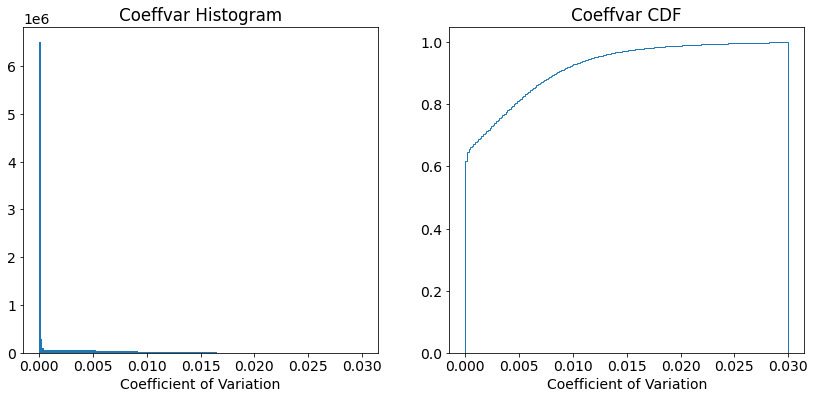

In [80]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(14, 6)) # Initialize figure with a size
ax1 = fig.add_subplot(121)  # 121 determines: 2 rows, 2 plots, first plot
ax2 = fig.add_subplot(122)
# Second plot: Histogram
# IMPORTANT: To get a histogram, we first need to *flatten* 
# the two-dimensional image into a one-dimensional vector.
h = ax1.hist(coeffvar.flatten(), bins=200, range=(0, 0.03))
ax1.xaxis.set_label_text('Coefficient of Variation')
ax1.set_title('Coeffvar Histogram')
plt.grid()
n, bins, patches = ax2.hist(coeffvar.flatten(), bins=200, range=(0, 0.03), cumulative='True', density='True', histtype='step', label='Empirical')
ax2.xaxis.set_label_text('Coefficient of Variation')
ax2.set_title('Coeffvar CDF')
plt.grid()
plt.savefig(f'{output_path}/thresh_coeff_var_histogram.png', dpi=72, transparent='true')

<font face="Calibri" size="3"><b>Plot the Threshold Coefficient of Variance Map and save it as a png (Coeffvarthresh.png):</b> </font> 

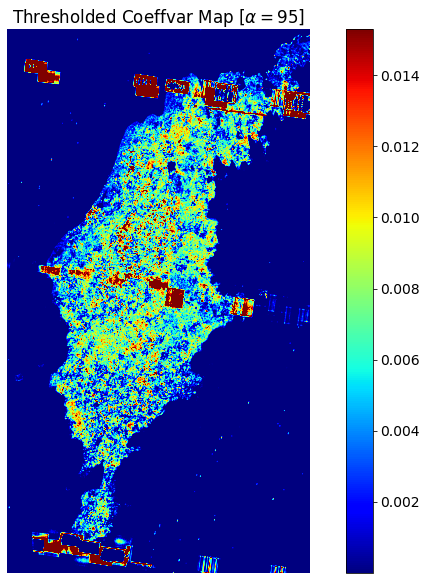

In [81]:
plt.rcParams.update({'font.size': 14})
outind = np.where(n > 0.80)
threshind = np.min(outind)
thresh = bins[threshind]
coeffvarthresh = np.copy(coeffvar)
coeffvarthresh[coeffvarthresh < thresh] = 0
coeffvarthresh[coeffvarthresh > 0.1] = 0
fig = plt.figure(figsize=(13, 10))
ax = fig.subplots()
ax.axis('off')
vmin = np.percentile(coeffvar.flatten(), 5)
vmax = np.percentile(coeffvar.flatten(), 95)
ax.set_title(r'Thresholded Coeffvar Map [$\alpha=95%$]')
im = ax.imshow(coeffvarthresh, cmap='jet', vmin=vmin, vmax=vmax)
bar = fig.colorbar(im, ax=ax)
plt.savefig(f'{output_path}/Coeffvarthresh.png', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the Threshold Coefficient of Variance Map as a GeoTiff (Coeffvarthresh.tiff):</b> </font> 

In [82]:
%%capture
geotiff_from_plot(coeffvarthresh, f'{output_path}/Coeffvarthresh', aoi_coords, cmap='jet', vmin=vmin, vmax=vmax)

<font face="Calibri" size="2"> <i>Time_Series_HyP3_v2.ipynb - Version 3.3 - October 2020 </i>
        <br>
        <b>Version Changes:</b>
    <ul>
        <li>Capture matplotlib deprecation warnings in import cell</li>
        <li>Handle breaking gdal update affecting gdalinfo json output</li> 
    </ul>
</font>